# Low rank / SVD approximation of Ibis and other shapes

Just playing with things for now. The main gist of it is that if an image is a matrix (in this case square and greyscale) $\mathbf{I}$, then the SVD,

$$
\mathbf{I} = \mathbf{U} \mathbf{S} \mathbf{V}^T
$$

gives us the optimal low-rank approximation of the image, that is

$$
\mathbf{I}^{(n)} = \sum_{k=1}^n \mathbf{S}_{k,k} \, \mathbf{u}_k \, \mathbf{v}_k^T
$$

where $\mathbf{u}_k$ is the $k$-th column of $\mathbf{U}$ and similar for $\mathbf{v}_k$, is the optimal $n$-rank approximation of $\mathbf{I}$.

In [1]:
import numpy as np
import math
import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageFilter
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

img_file = "./ibis.jpg"
img = rgb2gray(np.asarray(Image.open(img_file)))
img = img[15:-15, 24:-24] # Make it square...

U,S,V = np.linalg.svd(img)
V = V.T

print('Image dimensions: ', img.shape)

Image dimensions:  (1000, 1000)


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

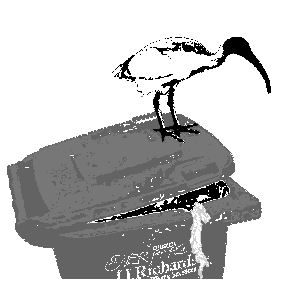

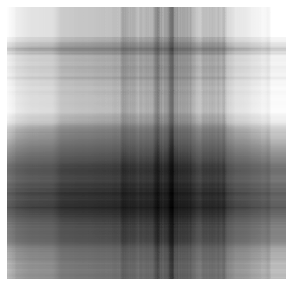

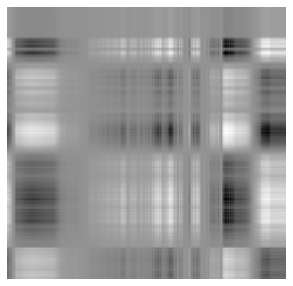

In [8]:
fig = plt.figure(figsize=(5, 5))
sns.heatmap(img, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r')
plt.savefig('./img/ibis.png')
plt.show()

fig = plt.figure(figsize=(5, 5))
sns.heatmap(U[:,0][:,np.newaxis] * V[:,0], xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r')
plt.savefig('./img/ibis_component_1.png')
plt.show()

fig = plt.figure(figsize=(5, 5))
sns.heatmap(U[:,1][:,np.newaxis] * V[:,1], xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r')
plt.savefig('./img/ibis_component_2.png')
plt.show()

fig = plt.figure(figsize=(5, 5))
sns.heatmap(U[:,2][:,np.newaxis] * V[:,2], xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r')
plt.savefig('./img/ibis_component_3.png')
plt.show()

# Ibis partial tensor sums

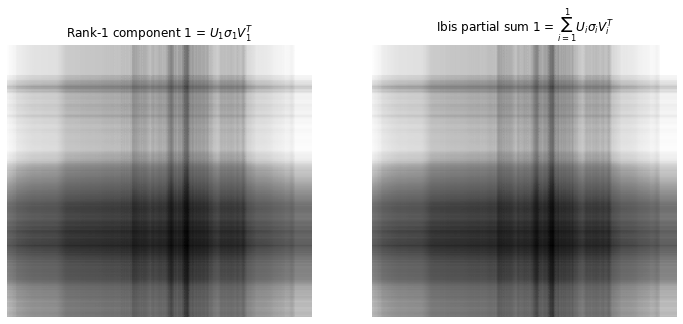

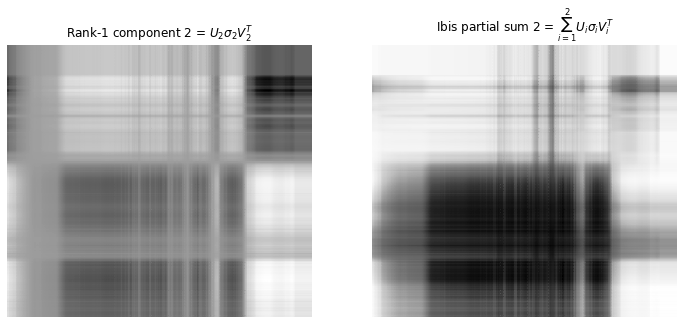

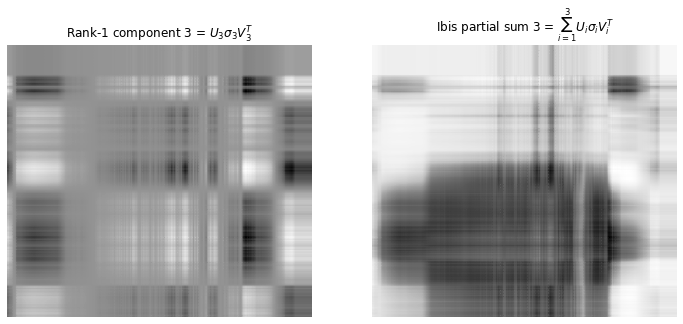

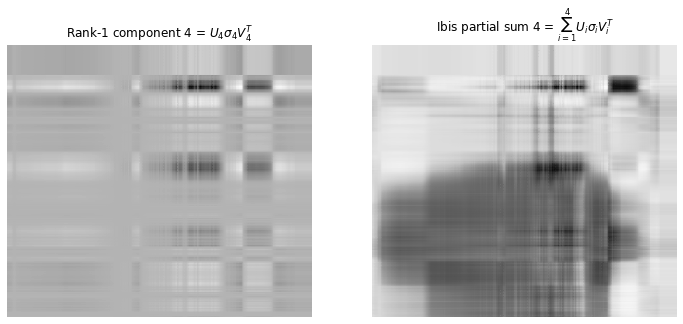

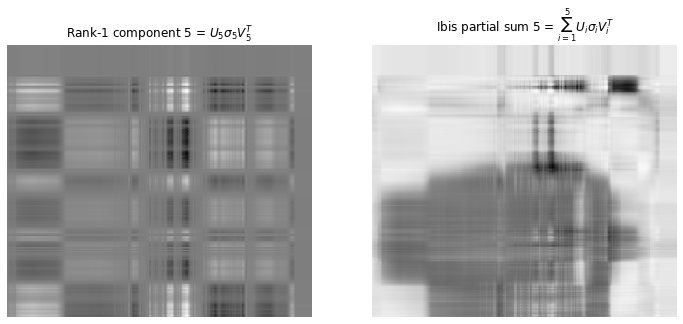

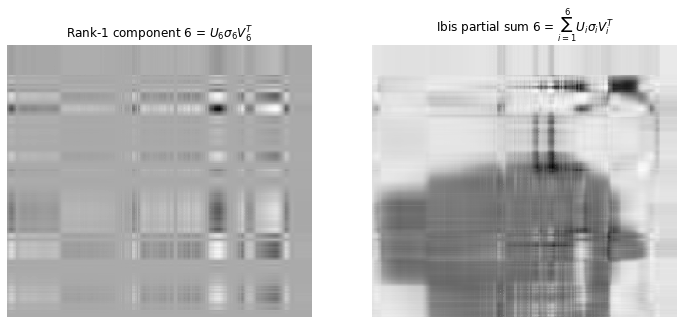

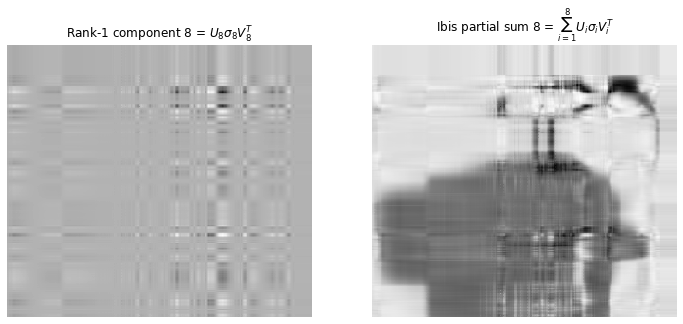

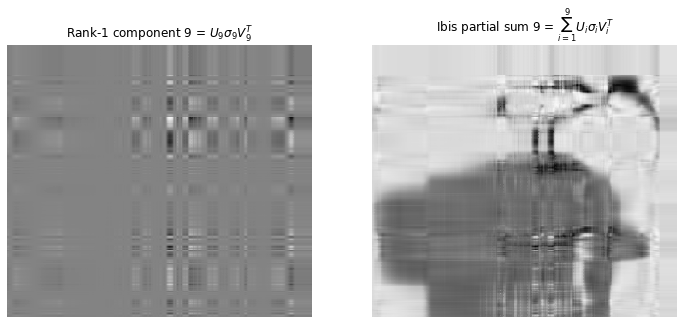

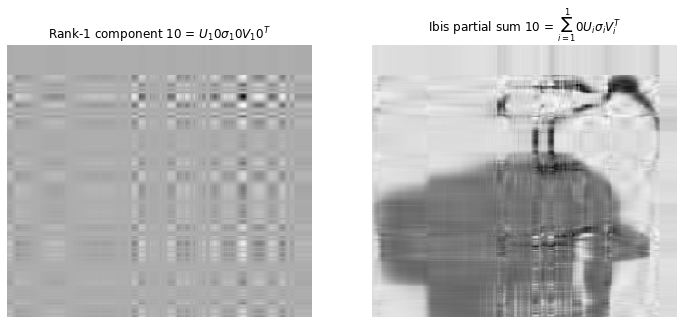

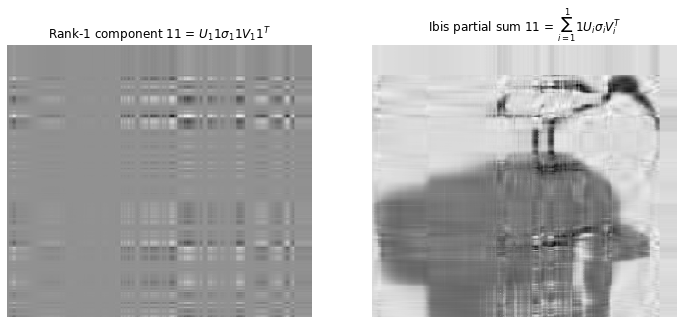

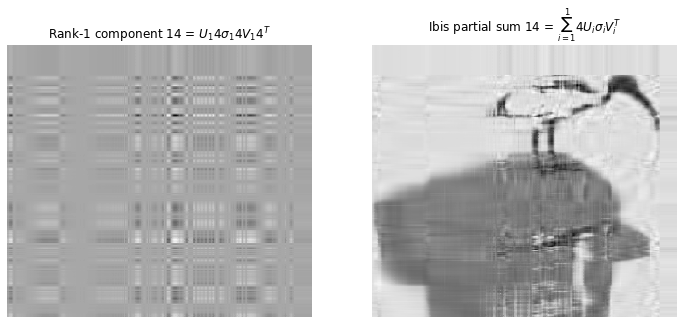

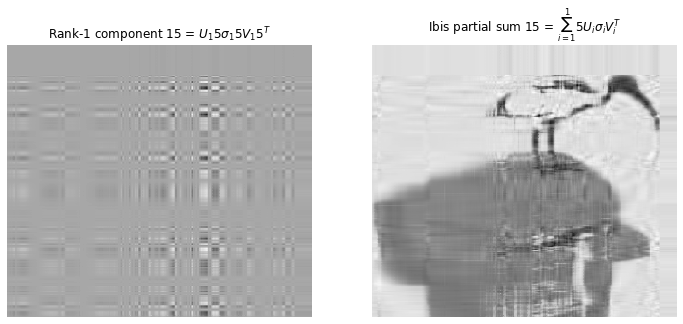

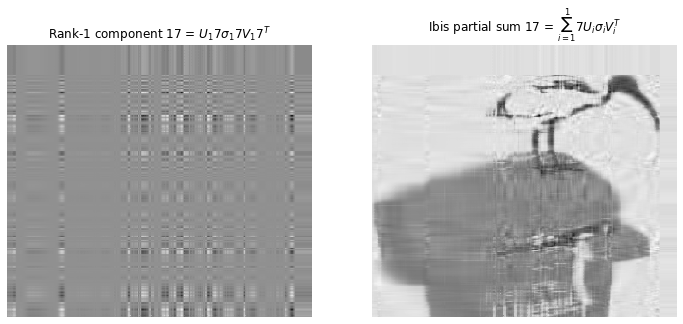

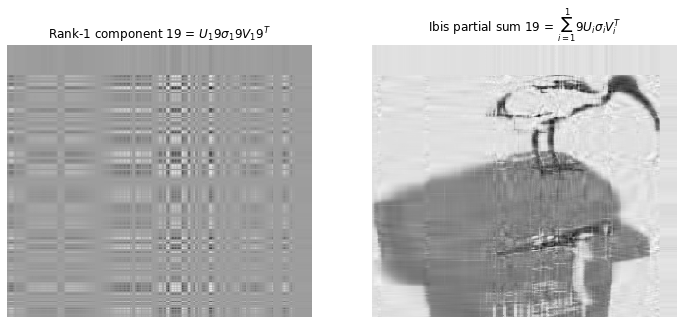

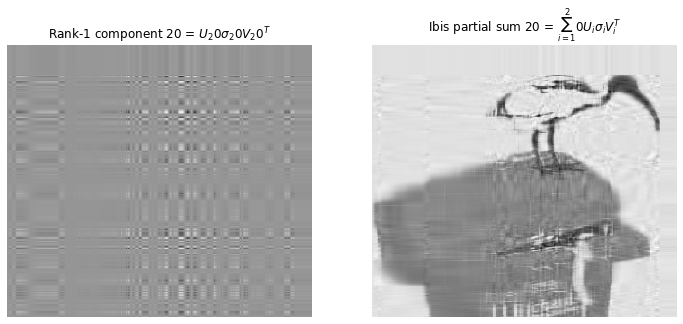

In [9]:
N = 20

tensor_sums = np.zeros(img.shape + (N,))

tensor_sums[:,:,0] = S[0] * U[:,0][:,np.newaxis] * V[:,0]
for i in range(1,N):
    tensor_sums[:,:,i] = tensor_sums[:,:,i-1] + S[i] * U[:,i][:,np.newaxis] * V[:,i]


for i in range(N):    
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(S[i] * U[:,i][:,np.newaxis] * V[:,i], xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r', ax=ax)
    ax.set_title(f'Rank-1 component {i+1} = $U_{i+1} \sigma_{i+1} V_{i+1}^T$')
    ax = fig.add_subplot(1,2,2)
    sns.heatmap(tensor_sums[:,:,i], xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r', ax=ax)
    ax.set_title(f'Ibis partial sum {i+1} = $\sum_{{i=1}}^{i+1} U_{{i}} \sigma_{{i}} V_{{i}}^T$ ')
    plt.savefig(f'./img/ibis_partial_sum_{i+1}.png')
    plt.show()

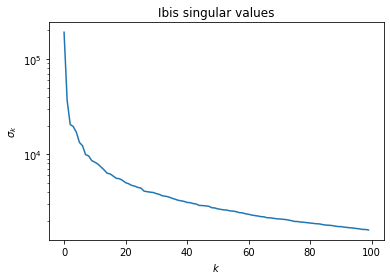

In [10]:
plt.semilogy(S[:100])
plt.title('Ibis singular values')
plt.ylabel(r'$\sigma_k$')
plt.xlabel(r'$k$')
plt.show()

# Decomposition of a triangle

We'll try a simple geometric shape here.

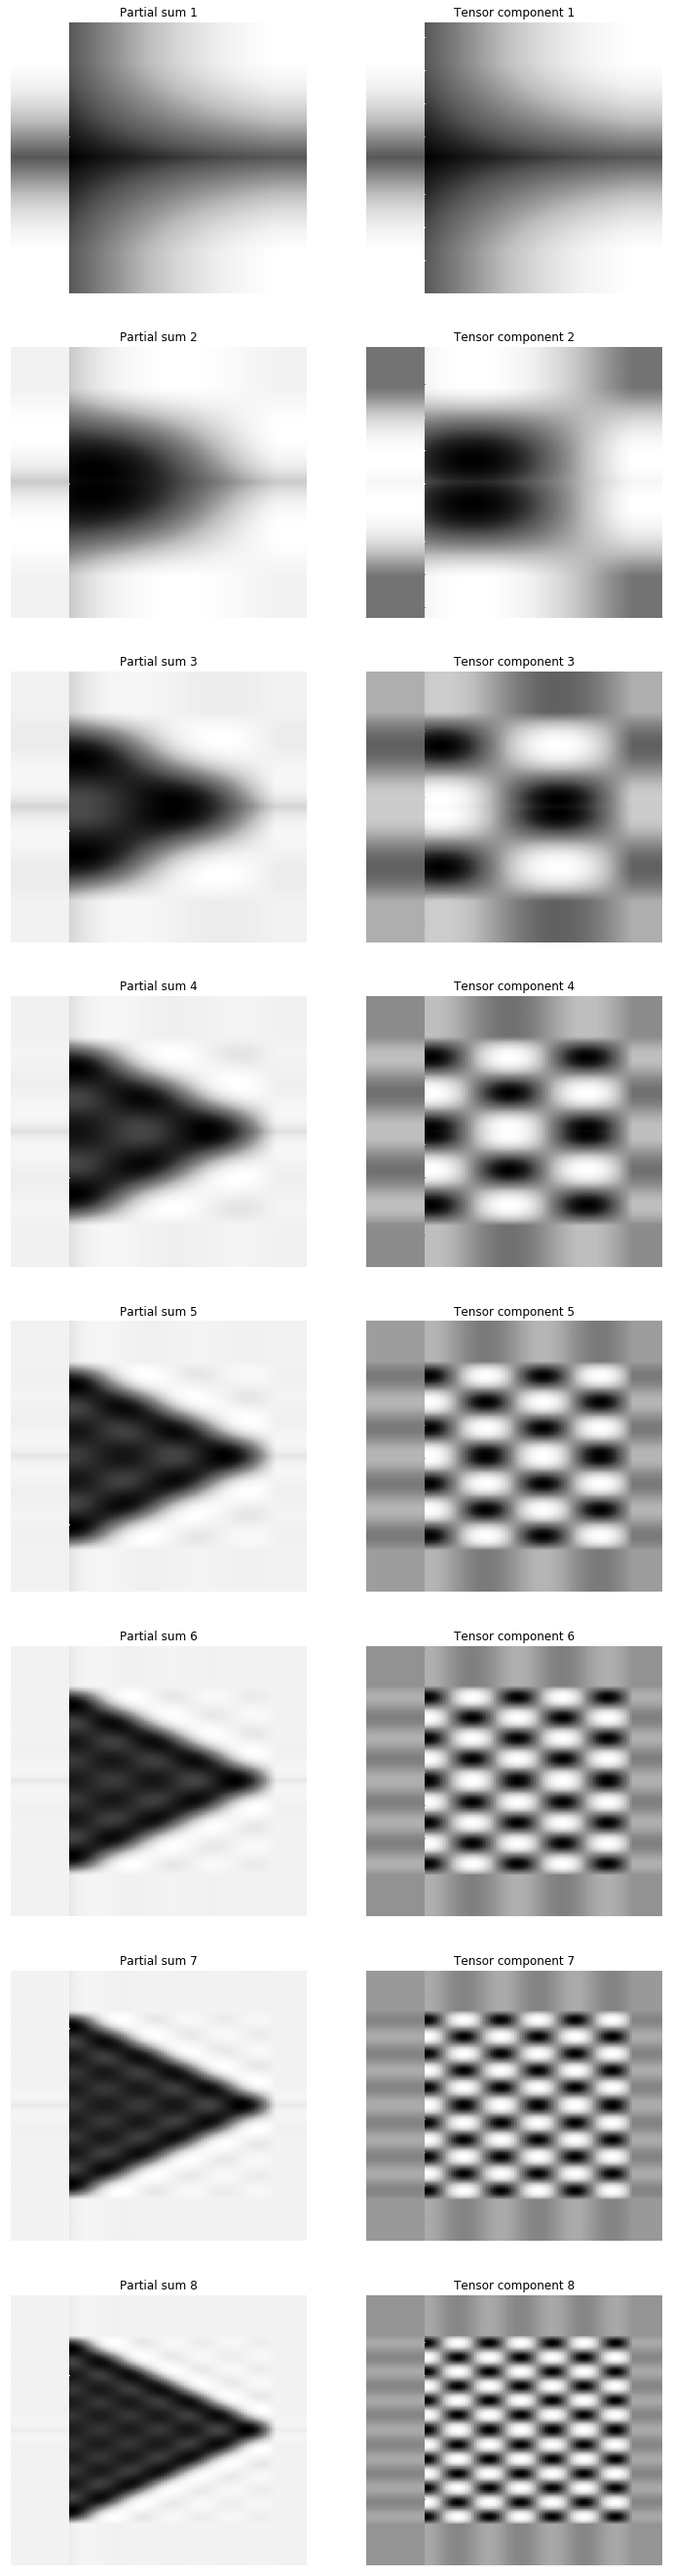

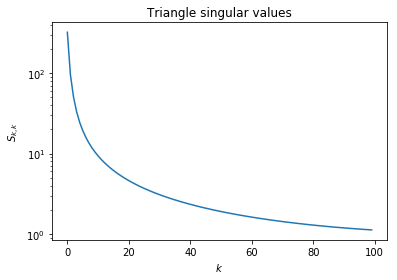

In [46]:
size = 400
grid = np.linspace(0, 1, size)

line_1 = lambda x: 2.*x - 0.1
line_2 = lambda x: -2.*x + 2.-0.1
line_3 = lambda x: 0.2

tri = (line_1(grid[:,None]) >= grid[None,:]) & (line_2(grid[:,None]) >= grid[None,:]) & (line_3(grid[:,None]) <= grid[None,:])
tri = 1 - tri

U_tri, S_tri, V_tri = np.linalg.svd(tri)
V_tri = V_tri.T

fig = plt.figure(figsize=(6, 6))
sns.heatmap(tri, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r')
plt.title('Original image of triangle')
plt.show()

N = 8
tensor_sums = np.zeros(tri.shape)
fig = plt.figure(figsize=(12, 6*N))
for i in range(N):
    tensor_component = S_tri[i] * U_tri[:,i][:,np.newaxis] * V_tri[:,i]
    tensor_sums += tensor_component
    
    ax = fig.add_subplot(N,2,2*i+1)
    sns.heatmap(tensor_sums, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r', ax=ax)
    plt.title(f'Partial sum {i+1}')
    ax = fig.add_subplot(N,2,2*i+2)
    sns.heatmap(tensor_component, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r', ax=ax)
    plt.title(f'Tensor component {i+1}')
plt.show()

plt.semilogy(S_tri[:100])
plt.title('Triangle singular values')
plt.ylabel(r'$S_{k,k}$')
plt.xlabel(r'$k$')
plt.show()

# Create a movie of Ibis low-rank approximation
### Caution! This takes a while to run

In [ ]:
N = 1000

import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Ibis Approximation', artist='James Nichols',
                comment='Tensorized Ibis!')
writer = FFMpegWriter(fps=15, metadata=metadata)

fig = plt.figure(figsize=(6, 6))
writer.setup(fig, 'ibis_approximation.mp4')
tt_run_sum = S[0] * U[:,0][:,np.newaxis] * V[:,0]
sns.heatmap(tt_run_sum, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r')
plt.title(r'$I_{i,j} = \sum_{k=1}^n U_{i, k} S_{k} V_{k,j}$ with $n=0$')
for i in range(8):
    writer.grab_frame()
    
tt_run_sum += S[1] * U[:,1][:,np.newaxis] * V[:,1]
sns.heatmap(tt_run_sum, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r')
plt.title(r'$I_{i,j} = \sum_{k=1}^n U_{i, k} S_{k} V_{k,j}$ with $n=1$')
for i in range(8):
    writer.grab_frame()
    
for j in range(2,6):
    print(j)
    tt_run_sum += S[j] * U[:,j][:,np.newaxis] * V[:,j]
    for i in range(4):
        sns.heatmap(tt_run_sum, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r')
        plt.title(r'$I_{i,j} = \sum_{k=1}^n U_{i, k} S_{k} V_{k,j}$ with $n=$' + f'{j}')
        writer.grab_frame()

for j in range(6,14):
    tt_run_sum += S[j] * U[:,j][:,np.newaxis] * V[:,j]
    for i in range(2):
        sns.heatmap(tt_run_sum, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r')
        plt.title(r'$I_{i,j} = \sum_{k=1}^n U_{i, k} S_{k} V_{k,j}$ with $n=$' + f'{j}')
        writer.grab_frame()
        
for j in range(14,N):
    print(j)
    tt_run_sum += S[j] * U[:,j][:,np.newaxis] * V[:,j]
    sns.heatmap(tt_run_sum, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r')
    plt.title(r'$I_{i,j} = \sum_{k=1}^n U_{i, k} S_{k} V_{k,j}$ with $n=$' + f'{j}')
    writer.grab_frame()
writer.finish()

In [ ]:
# Now with update on the right
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Ibis Approximation', artist='James Nichols',
                comment='Tensorized Ibis!')
writer = FFMpegWriter(fps=15, metadata=metadata)

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
writer.setup(fig, 'ibis_approximation_updates_full.mp4')

tt_run_sum = S[0] * U[:,0][:,np.newaxis] * V[:,0]
sns.heatmap(tt_run_sum, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r', ax=ax1)
ax1.set_title(r'Approx image: $I^{(n)}_{i,j} = \sum_{k=1}^n U_{i, k} S_{k} V_{k,j}$, $n=0$')
sns.heatmap(tt_run_sum, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r', ax=ax2)
ax2.set_title(r'Tensor component: $U_{i, n} S_{n} V_{n, j}$, ' + r'$n=0$')
for i in range(12):
    writer.grab_frame()

update = S[1] * U[:,1][:,np.newaxis] * V[:,1]
tt_run_sum += update
sns.heatmap(tt_run_sum, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r', ax=ax1)
ax1.set_title(r'Approx image: $I^{(n)}_{i,j} = \sum_{k=1}^n U_{i, k} S_{k} V_{k,j}$, $n=1$')
sns.heatmap(update, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r', ax=ax2)
ax2.set_title(r'Tensor component: $U_{i, n} S_{n} V_{n, j}$, ' + r'$n=1$')
for i in range(12):
    writer.grab_frame()
    
for j in range(2,10):
    update = S[j] * U[:,j][:,np.newaxis] * V[:,j]
    tt_run_sum += update
    sns.heatmap(tt_run_sum, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r', ax=ax1)
    ax1.set_title(r'Approx image: $I^{(n)}_{i,j} = \sum_{k=1}^n U_{i, k} S_{k} V_{k,j}$, $n=$' + f'{j}')
    sns.heatmap(update, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r', ax=ax2)
    ax2.set_title(r'Tensor component: $U_{i, n} S_{n} V_{n, j}$, ' + rf'$n={{{j}}}$')
    for i in range(4):
        writer.grab_frame()

for j in range(10,20):
    update = S[j] * U[:,j][:,np.newaxis] * V[:,j]
    tt_run_sum += update
    sns.heatmap(tt_run_sum, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r', ax=ax1)
    ax1.set_title(r'Approx image: $I^{(n)}_{i,j} = \sum_{k=1}^n U_{i, k} S_{k} V_{k,j}$, $n=$' + f'{j}')
    sns.heatmap(update, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r', ax=ax2)
    ax2.set_title(r'Tensor component: $U_{i, n} S_{n} V_{n, j}$, ' + rf'$n={{{j}}}$')
    for i in range(2):
        writer.grab_frame()
        
for j in range(20,120):
    update = S[j] * U[:,j][:,np.newaxis] * V[:,j]
    tt_run_sum += update
    
    sns.heatmap(tt_run_sum, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r', ax=ax1)
    ax1.set_title(r'Approx image: $I^{(n)}_{i,j} = \sum_{k=1}^n U_{i, k} S_{k} V_{k,j}$, $n=$' + f'{j}')
    sns.heatmap(update, xticklabels=False, yticklabels=False, cbar=False, cmap='Greys_r', ax=ax2)
    ax2.set_title(r'Tensor component: $U_{i, n} S_{n} V_{n, j}$, ' + rf'$n={{{j}}}$')
    writer.grab_frame()
writer.finish()